## 순환 신경망으로 IMDB 리뷰 분류하기

### IMDB 리뷰 데이터셋

- 유명한 인터넷 영화 데이터베이스인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋

#### 자연어 처리, 말뭉치

자연어 처리(natural language proceccing; NLP)
- 컴퓨터를 사용해 인간의 언어를 처리하는 분야

- 세부 분야 > 음성 인식, 기계 번역, 감성 분석 등

말뭉치(corpus)
- 자연어 처리 분야에서의 훈련 데이터

- IMDB 리뷰 데이터셋도 하나의 말뭉치임

- 텍스트 자체를 신경망에 전달 x

- 컴퓨터에서 처리하는 모든 것은 어떤 숫자 데이터

- 합성곱 신경망에서 이미지를 다룰 때는 특별한 변환x > 이미지가 정수 픽셀값으로 이루어져 있기 때문

- 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 일반적인 방법은 데이터에 등장하는 단어마다 고유한 정수를 부여하는 것

- 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리

- 토큰(token) : 분리된 단어
- 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 1개의 토큰은 하나의 타임스텝에 해당

- 한글은 조사가 발달되어 있기 때문에 공백으로 나누는 것만으로는 부족

- 일반적으로 한글은 형태소 분석을 통해 토큰을 만든다

- 토큰에 할당하는 정수 중에 몇 개는 특정한 용도로 예약되어 있는 경우가 많다

- ex) 0 -> 패딩, 1 -> 문장의 시작, 2 -> 어휘 사전에 없는 토큰

- 어휘 사전 : 훈련 세트에서 고유한 단어를 뽑아 만든 목록

- 실제 IMDB 리뷰 데이터셋은 영어로 된 문장이지만 편리하게 텐서플로에는 이미 정수로 바꾼 데이터가 포함

In [36]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words = 500
)

In [37]:
# 훈련 세트와 테스트 세트 크기 확인
print(train_input.shape, test_input.shape)

(25000,) (25000,)


- IMDB 리뷰 텍스트는 길이가 제각각

- 고정 크기의 2차원 배열에 담기 보다는 리뷰마다 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있다

- 이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열

- 넘파이 배열은 정수나 실수 외에도 파이썬 객체를 담을 수 있다

In [38]:
# 첫 번째 리뷰의 길이 출력
print(len(train_input[0]))

218


In [39]:
# 두 번쨰 리뷰 길이 출력
print(len(train_input[1]))

189


In [40]:
# 첫 번째 리뷰 내용 출력
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- imdb.load_data() 함수는 전체 어휘 사전에 있는 단어를 등장 횟수 순서대로 나열한 다음 가장 많이 등장한 n개의 단어를 선택

In [41]:
# 타깃 데이터 출력
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


- 해결할 문제 : 리뷰가 긍정인지 부정인지
- 0 -> 부정

- 1 -> 긍정

In [42]:
# 훈련 세트에서 검증 세트 떼어 놓기
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [43]:
# 각 리뷰의 길이를 계산해 넘파이 배열에 담기
# > 넘파이 리스트 내포를 사용해 train_input의 원소를 순회하며 길이 재기
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [44]:
# 넘파이 mean() 함수와 median() 함수를 사용해 리뷰 길이의 평균과 중간값 구하기
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


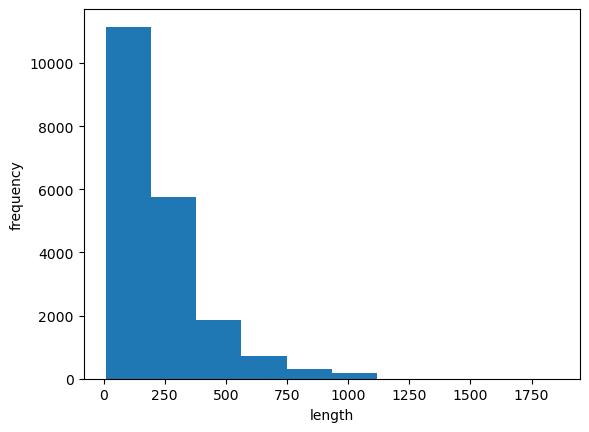

In [10]:
# lengths 배열을 히스토그램으로 표현
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [45]:
# train_input의 길이를 100으로 맞추기
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100)

- pad_sequences()

- maxlen에 원하는 길이를 지정하면 이보다 긴 경우는 잘라내고, 짧은 경우는 0으로 패딩을 함

In [46]:
# train_seq의 크기 확인
print(train_seq.shape)

(20000, 100)


- train_input은 파이썬 리스트의 배열이었지만 길이를 100으로 맞춘 train_seq는 이제 2차원 배열

In [47]:
# train_seq에 있는 첫 번째 샘플 출력
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [48]:
# train_input에 있는 원본 샘플 확인
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


- pad_sequences() 함수는 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 자른다

- 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문

- 시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences() 함수의 truncating 매개변수의 값을 기본값 pre가 아닌 post로 바꾸면 된다

In [49]:
# train_seq에 있는 여섯 번째 샘플 출력
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되므로 마지막에 패딩을 추가하는 것은 일반적으로 선호하지 x

- 하지만 원한다면 pad_sequences() 함수의 padding 매개변수의 기본값인 pre를 post로 바꾸면 샘플의 뒷부분에 패딩 추가 가능

In [50]:
# 검증 세트의 길이도 100으로 
val_seq = pad_sequences(val_input, maxlen=100)

### 순환 신경망 만들기

- Sequential 클래스는 순환 신경망뿐만 아니라 합성곱 신경망이나 일반적인 인공 신경망 모델을 모두 만들 수 있음

In [51]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100, 500)))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

/Users/youju/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- 순환층도 활성화 함수를 사용해야 함

- SimpleRNN 클래스의 activation 매개변수의 기본값은 tanh로 하이퍼볼릭 탄젠트 함수를 사용

원-핫 인코딩
- 정숫값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법

- 정숫값을 배열에서 해당 정수 위치의 원소만 1이고 나머지는 모두 0으로 변환

In [52]:
# train_seq를 원-핫 인코딩으로 변환하여 train_oh 배열 만들기
train_oh = keras.utils.to_categorical(train_seq)

In [53]:
# 배열의 크기 출력
print(train_oh.shape)

(20000, 100, 500)


In [54]:
# train_oh의 첫 번쩨 샘플의 첫 번째 토큰 10이 잘 인코딩되었는지 출력
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [55]:
# 모든 원소의 값을 더해서 1이 되는지 확인
print(np.sum(train_oh[0][0]))

1.0


In [56]:
# 같은 방식으로 val_seq도 원-핫 인코딩으로 바꾸기
val_oh = keras.utils.to_categorical(val_seq)

In [57]:
# 모델의 구조 출력
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 8)              │         4,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,081 (15.94 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 0 (0.00 B)

### 순환 신경망 훈련하기

- 순환 신경망의 훈련은 환전 연결 신경망이나 합성곱 신경망과 크게 다르지 않음

- 모델을 만드는 것은 달라도 훈련하는 방법은 모두 같음

<설계>
- 기본 RMSprop의 학습률을 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.0001로 지정

- 에포크 횟수를 100으로 늘리고 배치 크기는 64로 설정
- 그밖에 체크 포인트와 조기 종료를 구성하는 코드는 거의 동일

In [58]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4974 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.6998
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5125 - loss: 0.6952 - val_accuracy: 0.5176 - val_loss: 0.6944
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5543 - loss: 0.6850 - val_accuracy: 0.5788 - val_loss: 0.6787
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6015 - loss: 0.6695 - val_accuracy: 0.6280 - val_loss: 0.6614
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6452 - loss: 0.6485 - val_accuracy: 0.6584 - val_loss: 0.6400
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6787 - loss: 0.6259 - val_accuracy: 0.6808 - val_loss: 0.6221
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7018 - loss: 0.6031 - val_accuracy: 0.7044 - val_loss: 0.5994
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7212 - loss: 0.5815 -

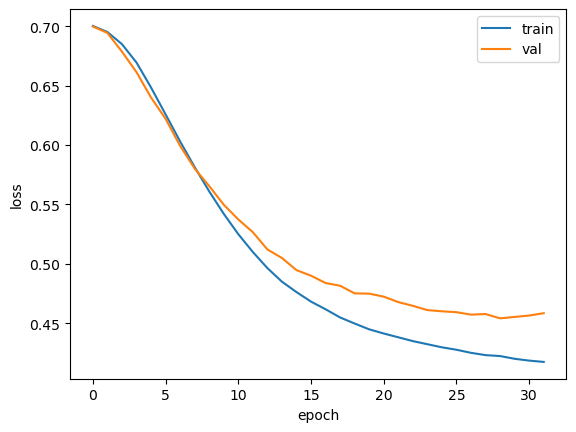

In [59]:
# 훈련 손실과 검증 손실을 그래프로 그려서 훈련 과정 살펴보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [60]:
# 실제로 train_seq 배열과 train_oh 배열의 nbytes 속성을 출력 크기 확인
print(train_seq.nbytes, train_oh.nbytes)

8000000 8000000000


### 단어 임베딩 사용하기

단어 임베딩(word embedding)
- 순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법

- 단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꿔줌

- 단어 임베딩으로 만들어진 벡터는 원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많다

- keras.layers 패키지 아래 Embedding 클래스로 제공
- 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습

- 단어 임베딩의 장점은 입력으로 정수 데이터를 받는다는 것

- 원-핫 인코딩으로 변경된 train_oh 배열이 아니라 train_seq를 사용할 수 있음
- 이 때문에 메모리를 훨씬 효율적으로 사용할 수 있음

In [61]:
# Embadding 클래스를 SimpleRNN 층 앞에 추가한 두 번째 순환 신경망 만들기
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [62]:
# 모델 구조 출력
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
train_seq = np.where(train_seq >= 200, 0, train_seq)
val_seq = np.where(val_seq >= 200, 0, val_seq)

In [68]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5425 - loss: 0.6883 - val_accuracy: 0.5752 - val_loss: 0.6783
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6269 - loss: 0.6487 - val_accuracy: 0.6458 - val_loss: 0.6360
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6796 - loss: 0.6108 - val_accuracy: 0.7000 - val_loss: 0.5957
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7013 - loss: 0.5918 - val_accuracy: 0.7014 - val_loss: 0.5885
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7041 - loss: 0.5834 - val_accuracy: 0.6980 - val_loss: 0.5844
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7107 - loss: 0.5752 - val_accuracy: 0.7126 - val_loss: 0.5713
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7189 - loss: 0.5689 - val_accuracy: 0.7152 - val_loss: 0.5700
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7168 - loss: 0.5657 - 

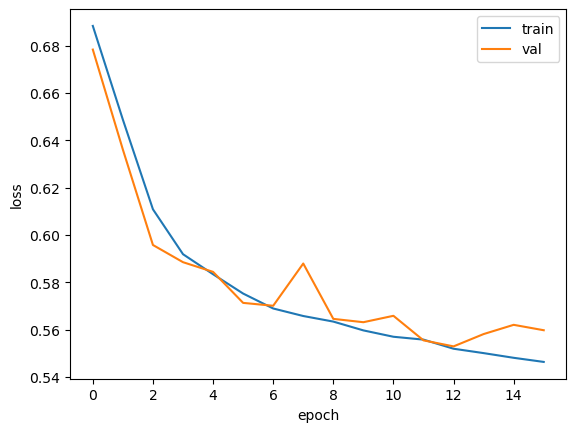

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()